In [1]:
import xcdat
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import zarr

import warnings
warnings.filterwarnings("ignore")

## Notes on xCDAT
` conda create -n <ENV_NAME> -c conda-forge xcdat xesmf matplotlib cartopy ipython ipykernel zarr `
 
* `xCDAT` requires `python>3.9`
* `xCDAT` has an argument `add_bounds` in the `open_dataset` function, which allows you to add bounds to the coordinates, vertical if you’re doing vertical regridding. `Add_bounds` is necessary only if the interpolation method we are using is `log` or `conservative`. For linear interpolations, add_bounds can be ignored. 
* Using `add_bounds` is only ideal when the vertical levels (`mid_levels`) are regularly spaced, which is not true for hybrid sigma pressure coordinates. I’m assuming climt uses hybrid sigma vertical coordinates since the data has variables.
    1. `atmosphere_hybrid_sigma_pressure_a_coordinate_on_interface_levels` 
    2. `atmosphere_hybrid_sigma_pressure_b_coordinate_on_interface_levels`
    
    
* And the `air_pressure_on_interface_levels` is calculated using these variables (a*Po + b*Ps)
* Since we are doing linear interpolation all these concerns can be ignored.

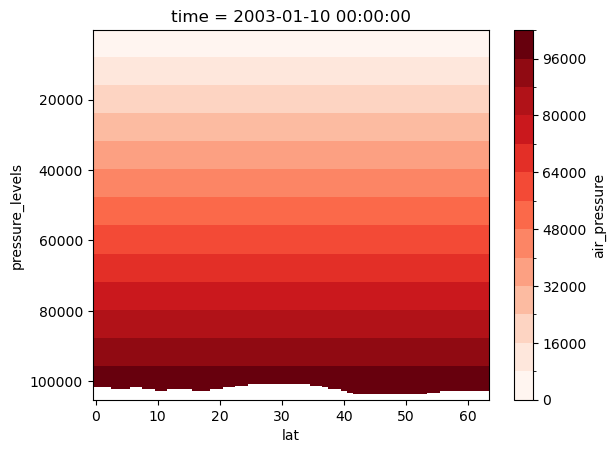

In [7]:

#if the data is in netcdf
#climt_data = xcdat.open_dataset('climatology_0.33_6.nc', add_bounds=None)

#if the data is in zarr 
climt_data = xcdat.open_dataset('climt_run/run_data',consolidated=False, engine="zarr", add_bounds=None)


#if your data doesnt have vertical coordinates
mid_levels = climt_data.mid_levels.values
climt_data = climt_data.assign_coords({"mid_levels": mid_levels})

#xCDAT requires the vertical axis have the name 'Z'. This can be added as an attr
climt_data['mid_levels'].attrs['axis'] = 'Z'
climt_data['lat'].attrs['units'] = "degrees_north"


# the axis name "lev" is not a choice, it's standard. Deviations will result in error
pressure_grid = xcdat.create_grid(z = xcdat.create_axis("lev",
                                                       np.arange(105000,0,-500)))
pressure = climt_data['air_pressure']
regridded_vars = []

for var_name, var_data in climt_data.data_vars.items():
    if 'mid_levels' in var_data.dims:
        output_var = climt_data.regridder.vertical(var_name,
                                                  pressure_grid,
                                                  method='linear',
                                                  target_data=pressure)
        regridded_vars.append(output_var)
        
    else:
        output_var = climt_data[var_name]
        regridded_vars.append(output_var)
        
merged_ds = xr.merge(regridded_vars)
merged_ds =  merged_ds.rename_dims({"lev": "pressure_levels"})
merged_ds = merged_ds.rename({"lev": "pressure_levels"})

#plotting air_pressure as a proof of credibility
merged_ds['air_pressure'][0].mean(dim='lon').plot(cmap="Reds", levels=15)
plt.gca().invert_yaxis()

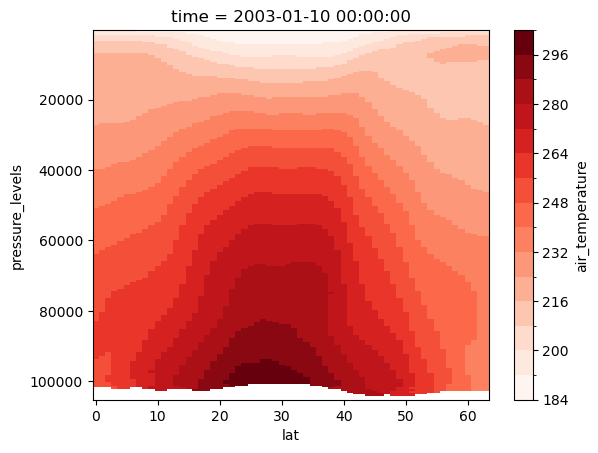

In [8]:
merged_ds['air_temperature'][0].mean(dim='lon').plot(cmap="Reds", levels=15)
plt.gca().invert_yaxis()